# Quantum representations of classical data tutorial

## Table of contents
- Qubit Lattice
- FRQI
- MCRQI

Information is an abstract concept that refers to something which has the *potential* to inform. Images are a kind of classical data which convey visual information. Operating with information may allow us to obtain *more* information. 

Information can be represented in an infinite number of ways, some useful, some not. 

Images are often represented using the RGB model, where one has three independent matrices, one for each primary color. But there also exists the HSI model, which represents and image via the hue, saturation and intensity.

It is pretty obvious that both of this representations are better suited, more efficient, to *inform* about the contents of an image compared to a flattened representation, despite containing essentially the same information.

In the quantum realm the same thing happens. With the added complication that we work with a less intuitive paradigm. 

In this tutorial we'll focus on images

QC in 3 lines.


Qubits are fancy bits. Bits are like a switch, qubits are like a fancy switch which can be correlated in a way simple switches cannot. As with bits, we have logical gates for fancy bits, aka qubits.

Fancy switches are a bit picky so they are vulnerable to noise and change their behaviour once you look at them.

# Introduction to QC with Qiskit

* qiskit
* qiskit-ibm-runtime
* 'qiskit[visualization]'

In [1]:
import qiskit
import qiskit_aer

In [2]:
# Registers
n_qubits = 5
n_bits   = 5

qReg = qiskit.QuantumRegister(n_qubits, "qReg") 
cReg = qiskit.ClassicalRegister(n_bits, 'cReg')

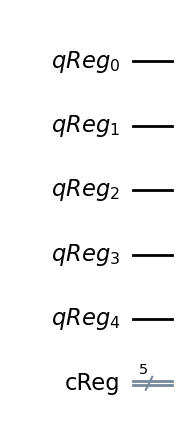

In [3]:
# Circuit
#   - a circuit is composed by registers
circuit = qiskit.QuantumCircuit(qReg, cReg)

circuit.draw(output='mpl')

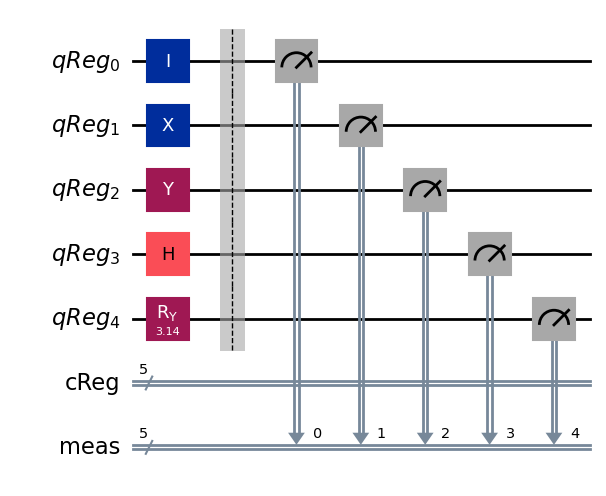

In [4]:
# Gates
#   - we can place gates in each register to do operations
circuit.id(0)
circuit.x(1)
circuit.y(2)
circuit.h(3)
circuit.ry(3.1415, 4)
circuit.measure_all()
circuit.draw(output='mpl')


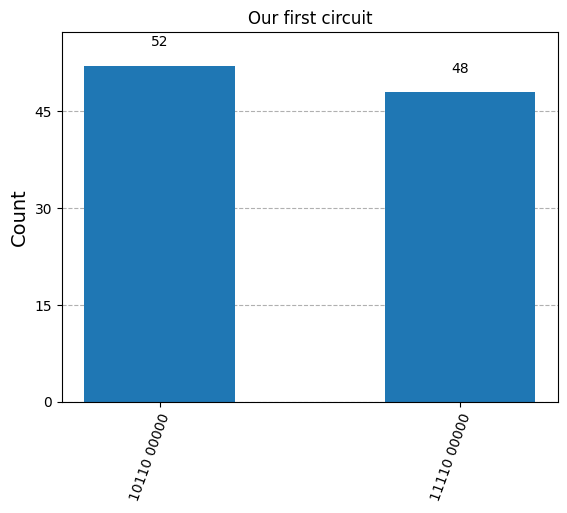

In [5]:
import qiskit.visualization


simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(circuit, simulator)

result = simulator.run(circuit, shots=100).result()
counts = result.get_counts(circuit)

qiskit.visualization.plot_histogram(counts, title="Our first circuit")

# Qubit lattice

The simplest way we can represent an image is via the *Qubit Lattice Representation*. As you will see this is a very non-efficient method but serves as a very good introduction point for quantum representations of images.

- We store the images as a lattice (matrix) of qubits.
- We store the color/intensity as $\theta$.    
  - interpolate the pixel value with an angle from 0 to $\pi$.
- We store three copies. (I think we can forget about this)

In [6]:
# 4 x 4 Image
import numpy as np
import matplotlib.pyplot as plt

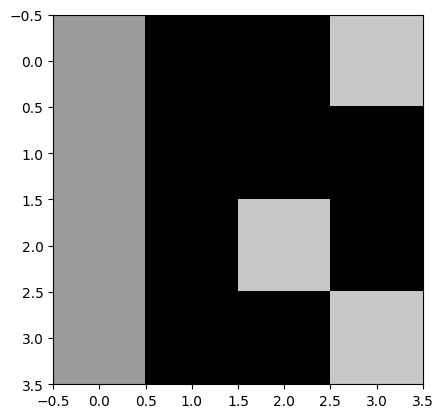

In [7]:
image = np.zeros((4,4), dtype=np.uint8)
image[0::1, 0] = 155  
image[2, 2] = 200
image[3, 3] = 200
image[0, 3] = 200

plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

How do we translate this image? we convert it to a flat vector and convert the pixel intensities to angles between zero and pi. 

In [8]:
signal = image.flatten()
signal = np.interp(signal, (0, 255), (0, np.pi))
pixels = len(signal)

In [9]:
qPixels = qiskit.QuantumRegister(pixels, 'qPixel')
qClassic = qiskit.ClassicalRegister(pixels, 'classic')

qubit_lattice = qiskit.QuantumCircuit(qPixels, qClassic)

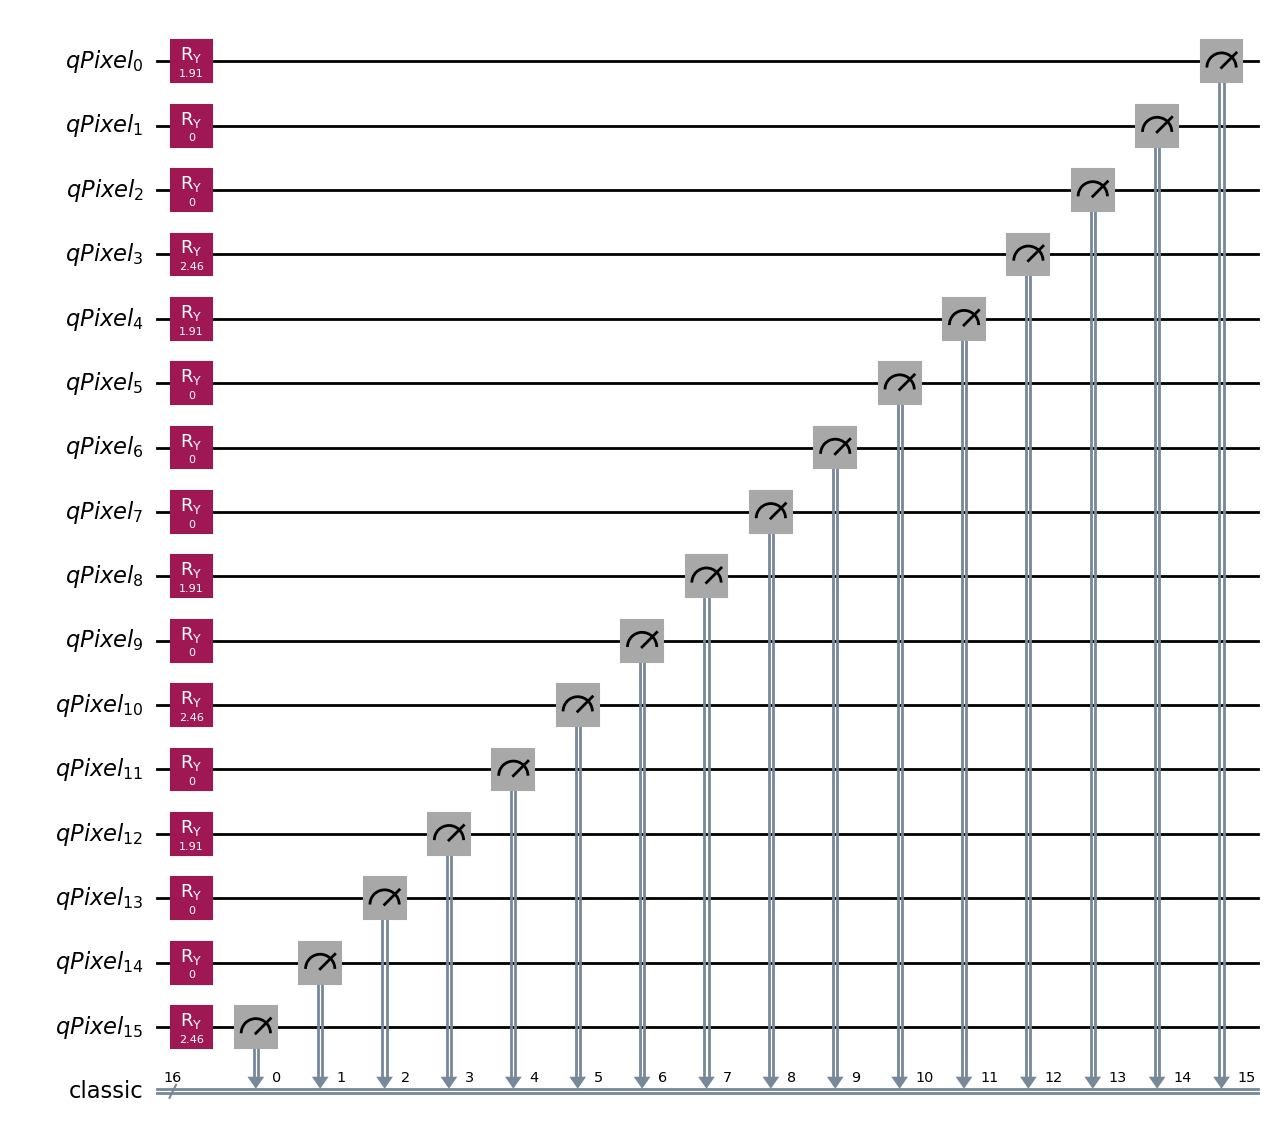

In [10]:
for idx, angle in enumerate(signal):
    qubit_lattice.ry(angle, idx)

qbits_to_measure = list(reversed(range(pixels)))
cbits_to_measure = range(pixels)
qubit_lattice.measure(qbits_to_measure, cbits_to_measure) 
qubit_lattice.draw('mpl')

In [11]:
print(qubit_lattice.depth())
print(qubit_lattice.num_qubits)

2
16


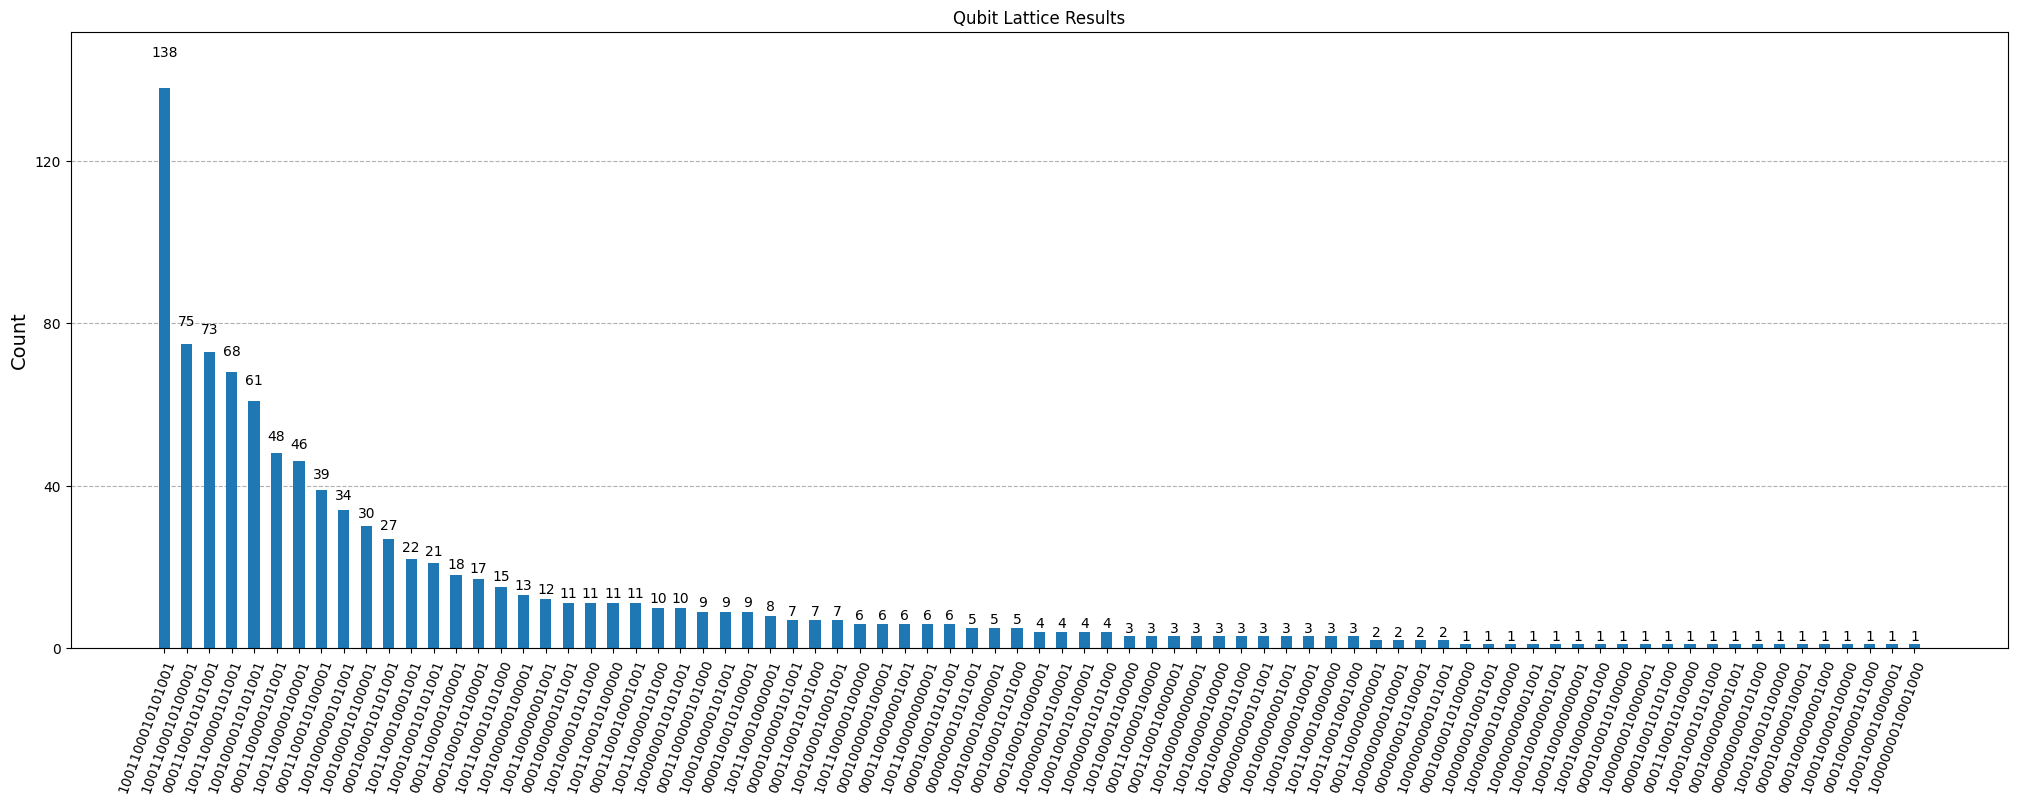

In [12]:
simulator = qiskit_aer.AerSimulator()
circuit = qiskit.transpile(qubit_lattice, simulator)
shots = 1000
result = simulator.run(circuit, shots=shots).result()
counts = result.get_counts(circuit)
qiskit.visualization.plot_histogram(counts, figsize=(25, 8), sort="value_desc", title="Qubit Lattice Results")

In [13]:
values = np.zeros((len(signal)))
for item in counts:
    for i, bit in enumerate(item):
        if bit=='0':
            values[i]+=counts[item]

values = values/shots
print(values)

[0.33  1.    1.    0.107 0.288 1.    1.    1.    0.346 1.    0.108 1.
 0.338 1.    1.    0.109]


In [14]:

reconstruct = []
for pixel in values:
    color = 2*np.arccos((pixel)**(1/2)) # "shots" corresponds to the total counts value.
    reconstruct.append(color)

In [15]:
reconstruct = list(np.interp(reconstruct, (0, np.pi), (0, 255)).astype(int))
reconstruct = np.reshape(reconstruct, (4,4))

[[155   0   0 200]
 [163   0   0   0]
 [152   0 200   0]
 [154   0   0 200]]
[[155   0   0 200]
 [155   0   0   0]
 [155   0 200   0]
 [155   0   0 200]]


In [23]:
print(reconstruct)
print('---------------------')
print(image)

[[155   0   0 200]
 [163   0   0   0]
 [152   0 200   0]
 [154   0   0 200]]
---------------------
[[155   0   0 200]
 [155   0   0   0]
 [155   0 200   0]
 [155   0   0 200]]


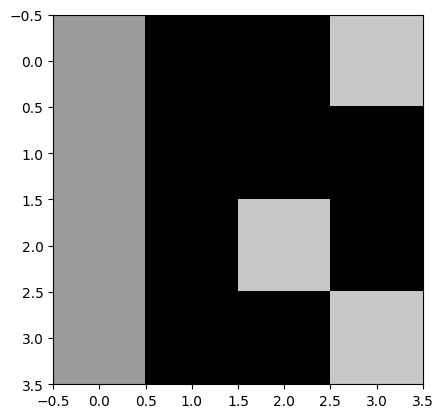

In [16]:
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title('')
#plt.axis('off')
plt.show()

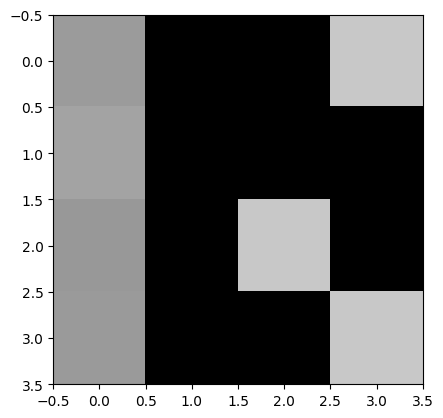

In [17]:
plt.imshow(reconstruct, cmap='gray', vmin=0, vmax=255)
plt.title('')
plt.show()

# FRQI

FRQI is the first *efficient* quantum representation of multi-channel images which exploits the *quantumness* of quantum computers.

In [27]:
import matplotlib.pyplot as plt
import math

We require $2n +1$ for representing a $2^n \times 2^n$ image.

In [26]:
flat_image = image.flatten()
flat_image

array([155,   0,   0, 200, 155,   0,   0,   0, 155,   0, 200,   0, 155,
         0,   0, 200], dtype=uint8)

In [29]:
angle_rep = np.interp(flat_image, (0, 255), (0, np.pi/2))

required_qubits = int(np.ceil(math.log(len(flat_image), 2)))
print(required_qubits)

4


$$|\text{FRQI}\rangle=\mathcal R \left(\mathcal H \left(|0\rangle^{\otimes 2n+1}\right)\right) $$


In [33]:
qRegCord = qiskit.QuantumRegister(required_qubits, 'coordinates')
qRegColor = qiskit.QuantumRegister(1, 'color')
cReg = qiskit.ClassicalRegister(qRegCord.size+qRegColor.size, 'bits')

frqi_circ = qiskit.QuantumCircuit(qRegColor, qRegCord, cReg)
n_qubits = frqi_circ.num_qubits

$$\text{FRQI}=\mathcal H \left(|0\rangle^{\otimes 2n+1}\right) \cdots $$

This gives us an equal weighted superposition of all states. We have the indices of all pixels, with an equal weight. We have a colorless image flat image (all gray)

In [34]:
frqi_circ.h(qRegCord)

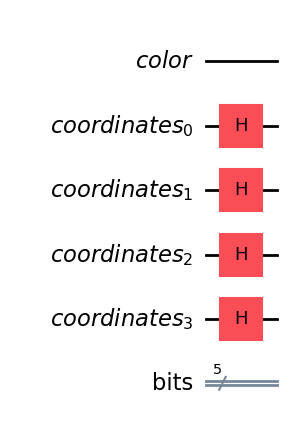

In [35]:
frqi_circ.draw('mpl')

In [37]:
controls = []
for i, _ in enumerate(qRegCord):
    controls.extend([qRegCord[i]]) # Store the no-target qubits (also named controls)
    
print(controls)

[Qubit(QuantumRegister(4, 'coordinates'), 0), Qubit(QuantumRegister(4, 'coordinates'), 1), Qubit(QuantumRegister(4, 'coordinates'), 2), Qubit(QuantumRegister(4, 'coordinates'), 3)]


In [38]:
for i, theta in enumerate(angle_rep):
    # Generate the different possible states of our qubits
    qubit_index_bin = "{0:b}".format(i).zfill(required_qubits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            frqi_circ.x(qRegCord[k]) # Apply X-gate to qubits in state '1'
    frqi_circ.barrier()
    
    # Applies the Ry multi-controlled gate to all the circuit qubits
    frqi_circ.mcry(theta=2*theta,
                  q_controls=controls,
                  q_target=qRegColor[0])
    
    frqi_circ.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            frqi_circ.x(qRegCord[k]) # Again, we apply X-gate to qubits in state '1'
    frqi_circ.barrier()

frqi_circ.measure(list(reversed(range(frqi_circ.num_qubits))), list(range(cReg.size)))

/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/uribagi/Documents/PhD/CVC/quantum-representations-of-classical-data/qrep-env/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


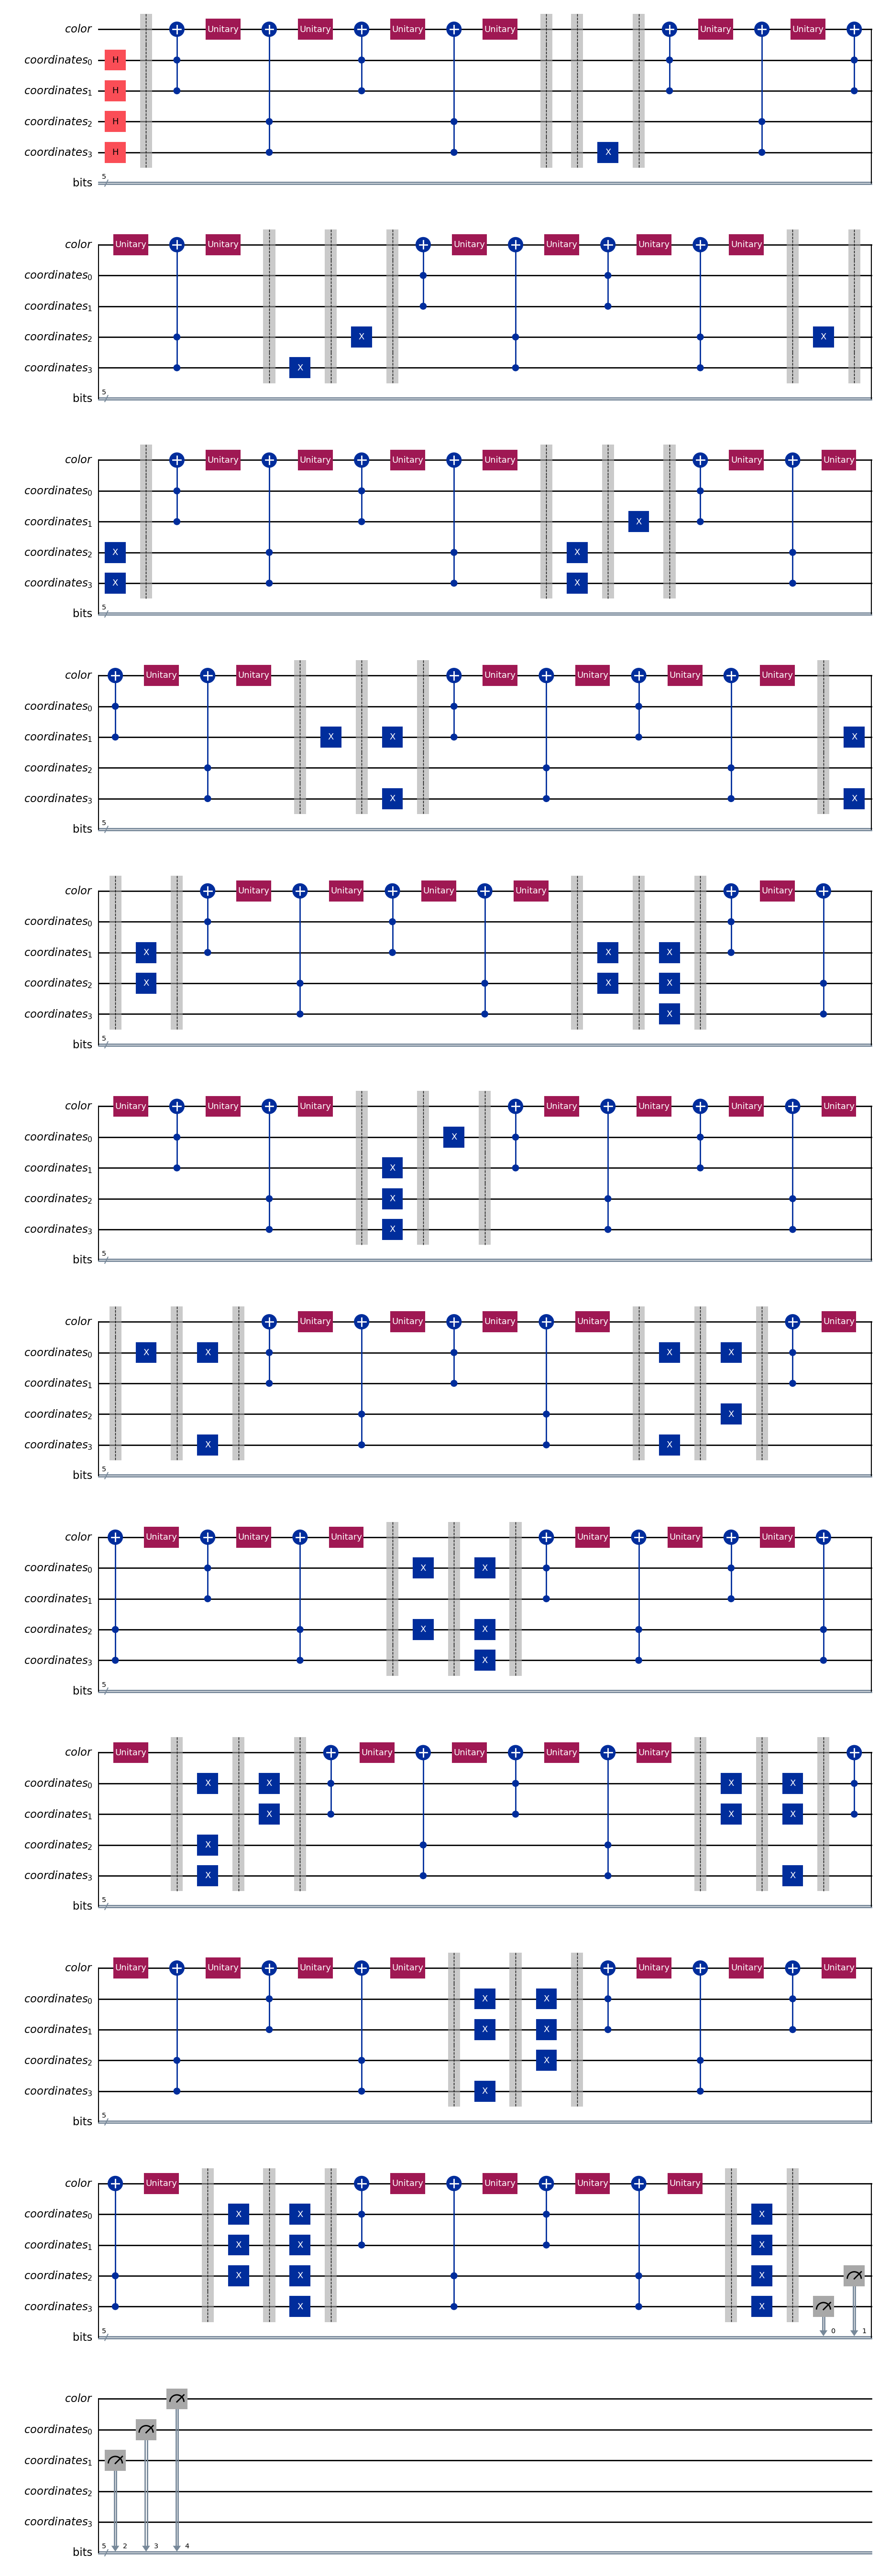

In [39]:
frqi_circ.draw('mpl')